In [2]:
import csv
import cv2
import numpy as np
import random

lines = []
with open("data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

correction_factor = 0.2
        
images = []
measurments = []
for line in lines:
    measurement = float(line[3])
    
    # Filter some of the near center samples
    if (measurement < 0.025 and measurement > -0.025 and random.choice([True, False])):
        continue
    for i in range(3):
        source_path = line[i] # 0 index is for the center camera
        filename = source_path.split('/')[-1]
        current_path = 'data/IMG/' + filename
        #print(current_path)
        image = cv2.imread(current_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB
        images.append(image)

        # Add the measurement for the given image
        if i == 0: # Center
            measurments.append(measurement)
        elif i == 1: # Left
            measurments.append(measurement + correction_factor)
        else: # i == 2 - Right
            measurments.append(measurement - correction_factor)

In [3]:
# Augment data
aug_images = []
aug_measurments = []

for image, measurment in zip(images, measurments):
    aug_images.append(image)
    aug_measurments.append(measurment)
    aug_images.append(cv2.flip(image, flipCode=1))
    aug_measurments.append(-measurment)

In [4]:
X_train = np.array(aug_images)
y_train = np.array(aug_measurments)

print("Number of training examples =", len(X_train))

Number of training examples = 23694


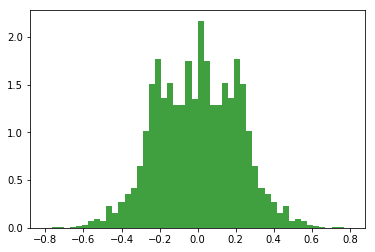

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
n, bins, patches = plt.hist(y_train, 50, normed=True, facecolor='green', alpha=0.75)

(160, 320, 3)


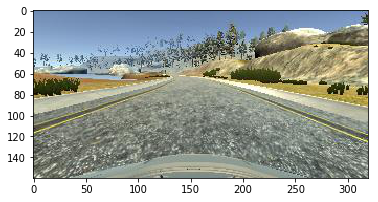

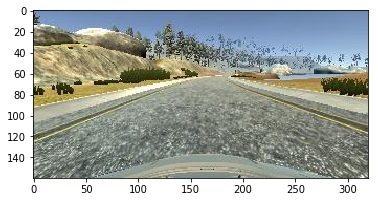

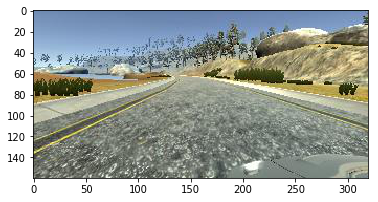

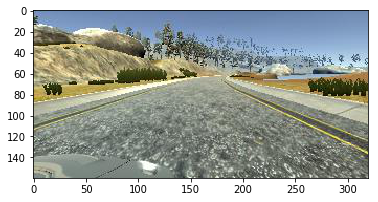

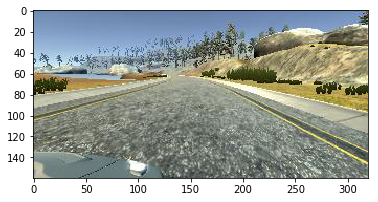

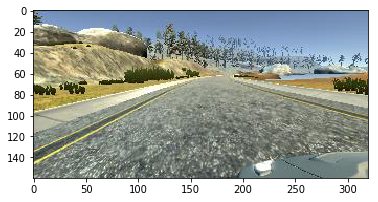

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

image_normal = X_train[0]
print(image_normal.shape)

for i in range(6):
    image = X_train[i]
    plt.figure(i)
    plt.imshow(image, cmap="gray")

# plt.figure(1)
# plt.imshow(image_normal, cmap="gray")

# plt.figure(2)
# plt.imshow(image_aug, cmap="gray")

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

# model = Sequential()
# model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160, 320, 3)))
# model.add(Flatten())
# model.add(Dense(1))

#LeNet
model = Sequential()
model.add(Cropping2D(cropping=((60,25), (0,0)), input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120))
model.add(Dropout(0.5))
model.add(Dense(84))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)
model.save('model.h5')

Train on 18955 samples, validate on 4739 samples
Epoch 1/5
18955/18955 [==============================] - 36s - loss: 0.0289 - acc: 0.0241 - val_loss: 0.0476 - val_acc: 0.0342
Epoch 2/5
18955/18955 [==============================] - 36s - loss: 0.0142 - acc: 0.0243 - val_loss: 0.0454 - val_acc: 0.0342
Epoch 3/5
18955/18955 [==============================] - 36s - loss: 0.0113 - acc: 0.0243 - val_loss: 0.0523 - val_acc: 0.0342
Epoch 4/5
18955/18955 [==============================] - 36s - loss: 0.0097 - acc: 0.0243 - val_loss: 0.0451 - val_acc: 0.0342
Epoch 5/5
18955/18955 [==============================] - 36s - loss: 0.0084 - acc: 0.0243 - val_loss: 0.0486 - val_acc: 0.0340


dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])


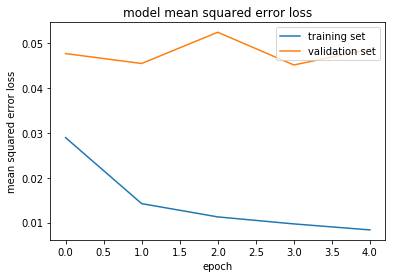

In [11]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

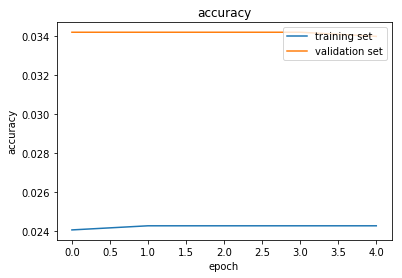

In [12]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()